# GCPUG発表用資料

In [2]:
from google.cloud.bigquery import magics
from google.oauth2 import service_account
credentials = (service_account.Credentials.from_service_account_file('../scalable-data-science-8a106588da7e.json'))
magics.context.credentials = credentials

In [3]:
%load_ext google.cloud.bigquery

In [4]:
PROJECT ='scalable-data-science'

# データの概観を眺める

In [14]:
%%bigquery --project $PROJECT 
SELECT 
    species,
    COUNT(*) AS count,
    AVG(sepal_length) AS avg,
    STDDEV(sepal_length) AS std,
    MAX(sepal_length) AS max,
    MIN(sepal_length) AS min,
    CORR(sepal_length, sepal_width) AS corr
FROM `bigquery-public-data.ml_datasets.iris` GROUP BY species

,species,count,avg,std,max,min,corr
0,versicolor,50,5.936,0.516171,7.0,4.9,0.525911
1,virginica,50,6.588,0.635880,7.9,4.9,0.457228
2,setosa,50,5.006,0.352490,5.8,4.3,0.746780


In [25]:
SELECT 
    species,
    APPROX_QUANTILES(sepal_length, 5) AS q
FROM `bigquery-public-data.ml_datasets.iris` GROUP BY species

,species,q
0,versicolor,"[4.9, 5.5, 5.7, 6.0, 6.4, 7.0]"
1,virginica,"[4.9, 6.1, 6.4, 6.7, 7.2, 7.9]"
2,setosa,"[4.3, 4.7, 4.9, 5.1, 5.3, 5.8]"


In [39]:
from google.cloud.bigquery import magics
from google.oauth2 import service_account
credentials = (service_account.Credentials.from_service_account_file('path/to/credentials.json'))
magics.context.credentials = credentials

%load_ext google.cloud.bigquery

PROJECT ='[PROJECT_NAME]'

In [34]:
%%bigquery data --project $PROJECT  
-- 変数名dataにBQの出力結果がDataFrameとして格納される
SELECT 
    species,
    AVG(sepal_length) AS avg
FROM `bigquery-public-data.ml_datasets.iris` GROUP BY species

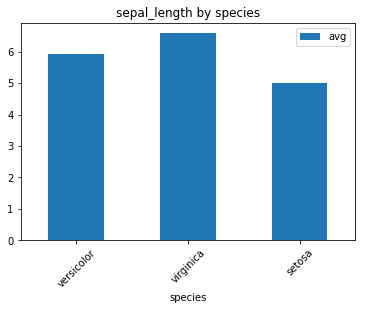

In [38]:
# matplotlibで可視化
data.plot(x='species', y='avg', kind='bar', title='sepal_length by species', rot= 45)